## Imports

In [1]:
from datetime import timedelta
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from darts import TimeSeries
from darts.models import FFT, LinearRegressionModel

## Dataset Preprocessing

In [2]:
df = pd.read_csv('online_retail_II.csv')

In [3]:
df["TotalPrice"] = df["Quantity"]*df["Price"]
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])
df['InvoiceDate'] = df['InvoiceDate'].dt.strftime('%Y-%m-%d')
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])

display(df, df.describe(),df.dtypes)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France,14.85


,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,1.067371e+06,1067371,1.067371e+06,824364.000000,1.067371e+06
mean,9.938898e+00,2011-01-02 07:41:55.613034496,4.649388e+00,15324.638504,1.806987e+01
min,-8.099500e+04,2009-12-01 00:00:00,-5.359436e+04,12346.000000,-1.684696e+05
25%,1.000000e+00,2010-07-09 00:00:00,1.250000e+00,13975.000000,3.750000e+00
50%,3.000000e+00,2010-12-07 00:00:00,2.100000e+00,15255.000000,9.900000e+00
75%,1.000000e+01,2011-07-22 00:00:00,4.150000e+00,16797.000000,1.770000e+01
max,8.099500e+04,2011-12-09 00:00:00,3.897000e+04,18287.000000,1.684696e+05
std,1.727058e+02,NaN,1.235531e+02,1697.464450,2.924202e+02


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
TotalPrice            float64
dtype: object

In [4]:
df_new = df.copy()
df_new.set_index("InvoiceDate", inplace = True)

In [5]:
resample_weekly = df_new[["Quantity", "TotalPrice"]].resample("W").sum().reset_index()
resample_daily = df_new[["Quantity", "TotalPrice"]].resample("D").sum().reset_index()

In [6]:
resample_weekly

,InvoiceDate,Quantity,TotalPrice
0,2009-12-06,136455,258496.32
1,2009-12-13,111826,232310.10
2,2009-12-20,133295,256240.20
3,2009-12-27,38512,52800.49
4,2010-01-03,0,0.00
...,...,...,...
101,2011-11-13,176997,346560.14
102,2011-11-20,179216,380407.57
103,2011-11-27,162568,308185.02
104,2011-12-04,151807,319874.99


In [7]:
series = TimeSeries.from_dataframe(resample_weekly, time_col="InvoiceDate", value_cols=["TotalPrice"])

Text(0.5, 1.0, 'Total Dataset')

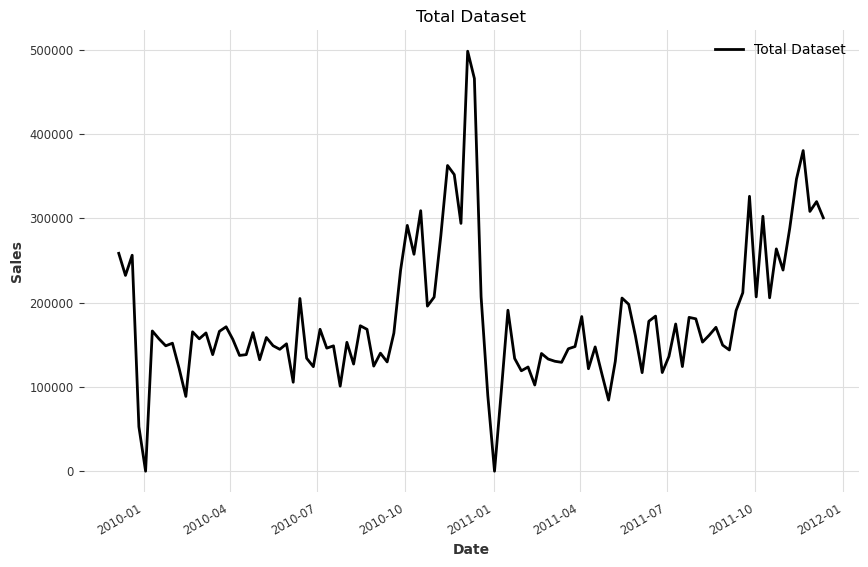

In [8]:
plt.figure(figsize=(10, 6))
series.plot(label = "Total Dataset", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Total Dataset")

## Data exploration

### Stationary Test

Why to test for stationarity?


Testing for stationarity is important in time series analysis because stationary series have consistent statistical properties over time, making them easier to model and predict. Non-stationary series with changing mean or variance may lead to inaccurate models.

In [9]:
from statsmodels.tsa.stattools import adfuller

series_values = series.values().flatten()
result = adfuller(series_values)

# Display the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -4.104289853741817
p-value: 0.0009528314573261567
Critical Values: {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}
The time series is likely stationary.


### Seasonality Test

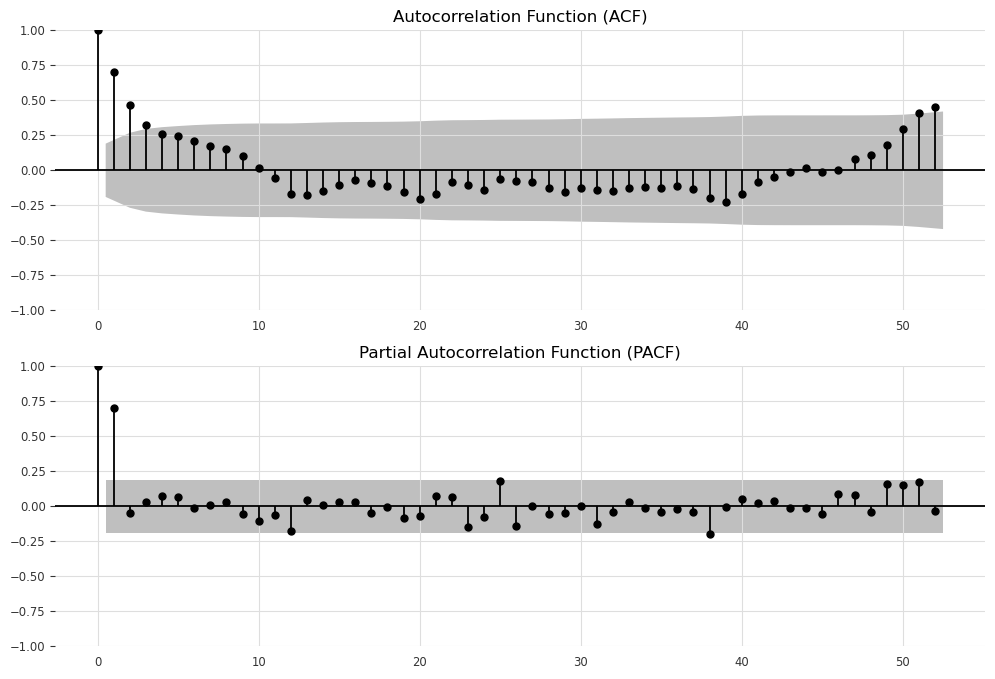

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(resample_weekly['TotalPrice'].dropna(), lags=52, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(resample_weekly['TotalPrice'].dropna(), lags=52, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

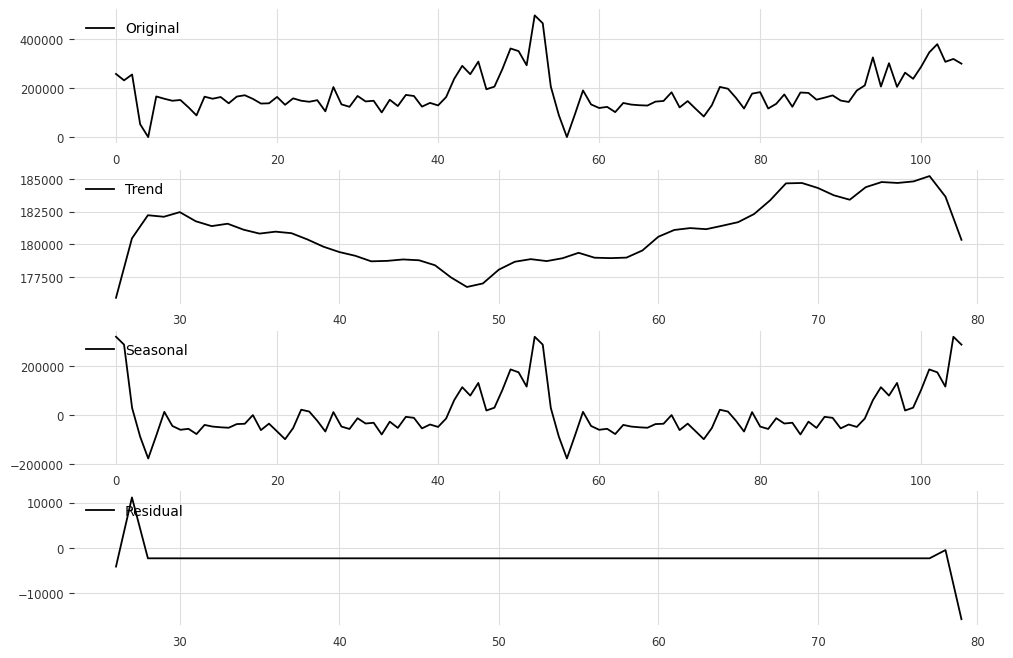

In [11]:
total_price_series = resample_weekly['TotalPrice']

result = seasonal_decompose(total_price_series, model='additive', period=52)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(total_price_series, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

## Train/Test Split

In [12]:
train, val = series[:-4],series[-4:]

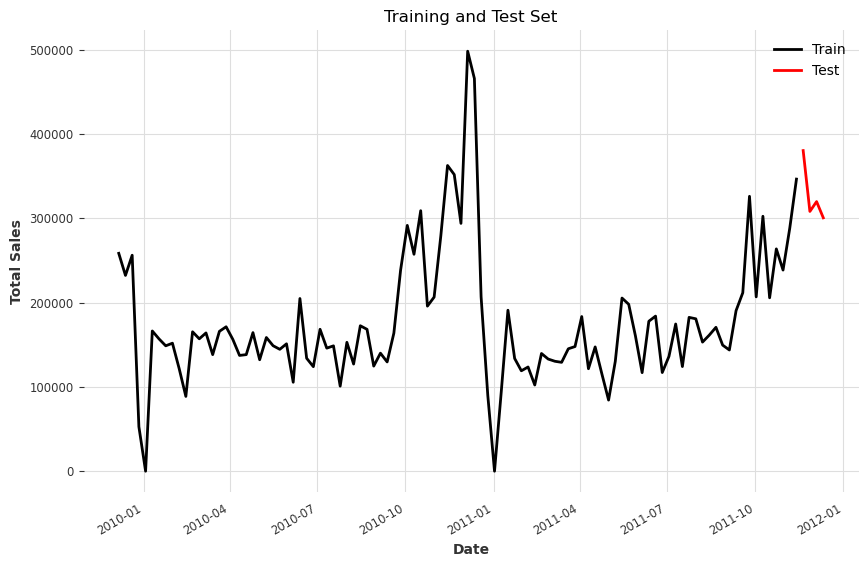

In [13]:
plt.figure(figsize=(10, 6))
train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2,color ="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Training and Test Set")
plt.legend()
plt.show()

## Models

### FFT

FFT is employed in forecasting to decompose time series data into its frequency components, aiding in the identification of dominant cycles, seasonality patterns, and improving the accuracy of forecasts by leveraging the inherent periodicities in the data.

In [14]:
model = FFT(nr_freqs_to_keep = 8)
model.fit(train)
fft_forecast = model.predict(len(val))

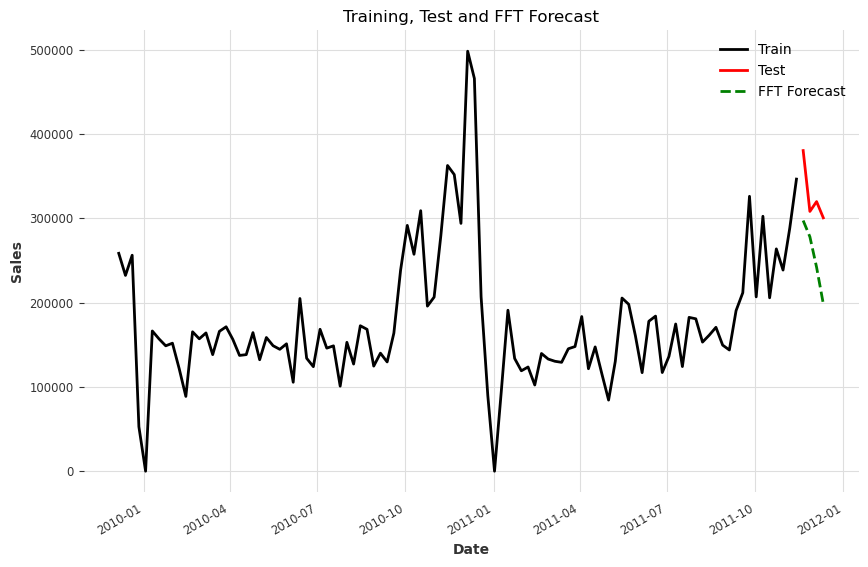

In [15]:
plt.figure(figsize=(10, 6))

train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2,color="red")
fft_forecast.plot(label="FFT Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training, Test and FFT Forecast")
plt.legend()
plt.show()

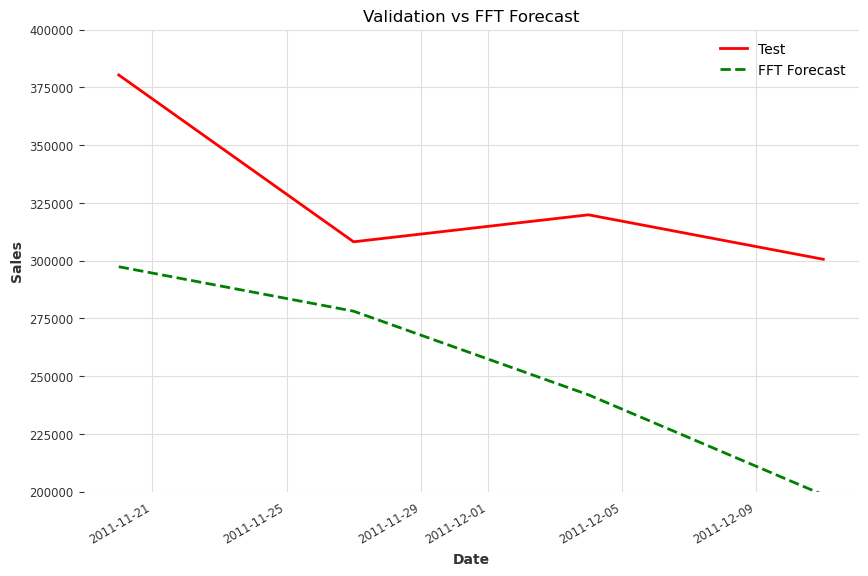

In [16]:
plt.figure(figsize=(10, 6))

val.plot(label="Test", linewidth=2,color = "red")
fft_forecast.plot(label="FFT Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Validation vs FFT Forecast")
plt.legend()
plt.ylim(200000, 400000)
plt.show()

In [17]:
fft_train_df = train.pd_dataframe()
fft_val_df = val.pd_dataframe()
fft_forecast_df = fft_forecast.pd_dataframe()

In [18]:
fft_mse= mean_squared_error(fft_val_df["TotalPrice"],fft_forecast_df["TotalPrice"])
fft_rmse= rmse(fft_val_df["TotalPrice"],fft_forecast_df["TotalPrice"])
fft_mape = mean_absolute_percentage_error(fft_val_df["TotalPrice"], fft_forecast_df["TotalPrice"])
fft_mae = mean_absolute_error(fft_val_df["TotalPrice"], fft_forecast_df["TotalPrice"])

print(f"FFT Mean Squared Error (MSE): {fft_mse}")
print(f"FFT Root Mean Squared Error (RMSE): {fft_rmse}")
print(f"FFT Mean Absolute Percentage Error (MAPE): {fft_mape}")
print(f"FFT Mean Absolute Error (MAE): {fft_mae}")

FFT Mean Squared Error (MSE): 6067478031.66025
FFT Root Mean Squared Error (RMSE): 77894.01794528415
FFT Mean Absolute Percentage Error (MAPE): 0.2246476914037172
FFT Mean Absolute Error (MAE): 73243.44430546404


### Simple Exponential Smoothing

SES is employed in forecasting for its adaptability to changing trends, simplicity, and effectiveness in smoothing time series data, making it a practical choice for quick and intuitive forecasting tasks.

In [19]:
es_train_df = train.pd_dataframe()
es_val_df = val.pd_dataframe()

model = SimpleExpSmoothing(es_train_df)
fit_model = model.fit(smoothing_level=0.5)
es_forecast = fit_model.forecast(len(val))

C:\Users\Bert\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


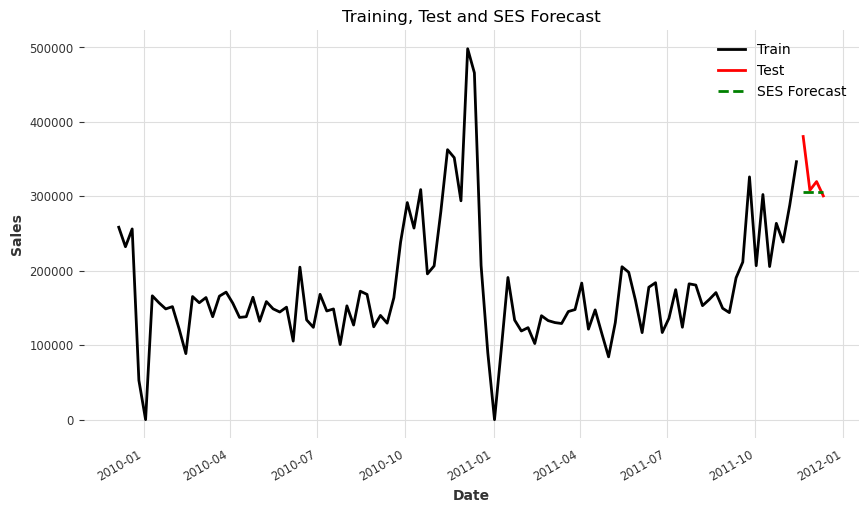

In [20]:
plt.figure(figsize=(10, 6))

train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2, color="red")
es_forecast.plot(label="SES Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training, Test and SES Forecast")
plt.legend()
plt.show()

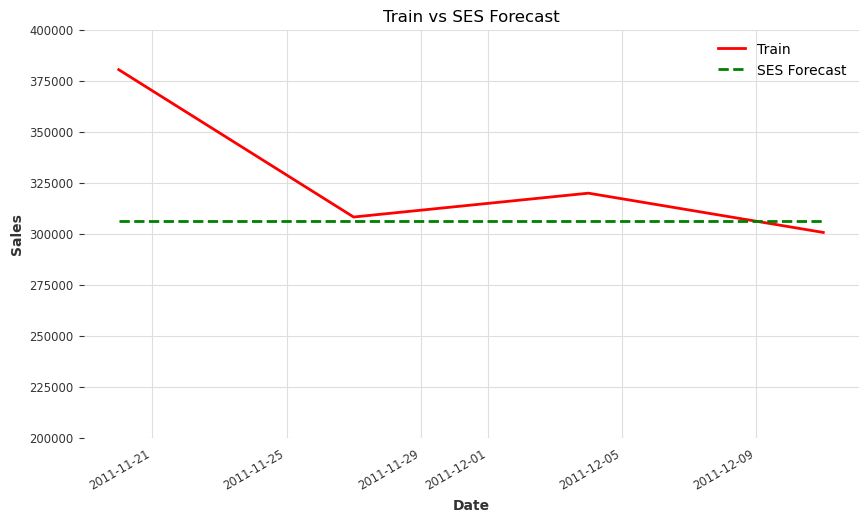

In [21]:
plt.figure(figsize=(10, 6))

val.plot(label="Train", linewidth=2,color ="red")
es_forecast.plot(label="SES Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Train vs SES Forecast")
plt.ylim(200000, 400000)
plt.legend()
plt.show()

In [22]:
es_mse = mean_squared_error(es_val_df["TotalPrice"], es_forecast.values)
es_rmse = rmse(es_val_df["TotalPrice"], es_forecast.values)
es_mape = mean_absolute_percentage_error(es_val_df["TotalPrice"], es_forecast.values)
es_mae = mean_absolute_error(es_val_df["TotalPrice"], es_forecast.values)

print(f"SES Mean Squared Error (MSE): {es_mse}")
print(f"SES Root Mean Squared Error (RMSE): {es_rmse}")
print(f"SES Mean Absolute Percentage Error (MAPE): {es_mape}")
print(f"SES Mean Absolute Error (MAE): {es_mae}")


SES Mean Squared Error (MSE): 1421542680.5151446
SES Root Mean Squared Error (RMSE): 37703.351051533136
SES Mean Absolute Percentage Error (MAPE): 0.06534324090151471
SES Mean Absolute Error (MAE): 23733.85825890761


### Linear Regression

In [23]:
model = LinearRegressionModel(lags=20)
model.fit(train)
lg_forecast = model.predict(len(val))

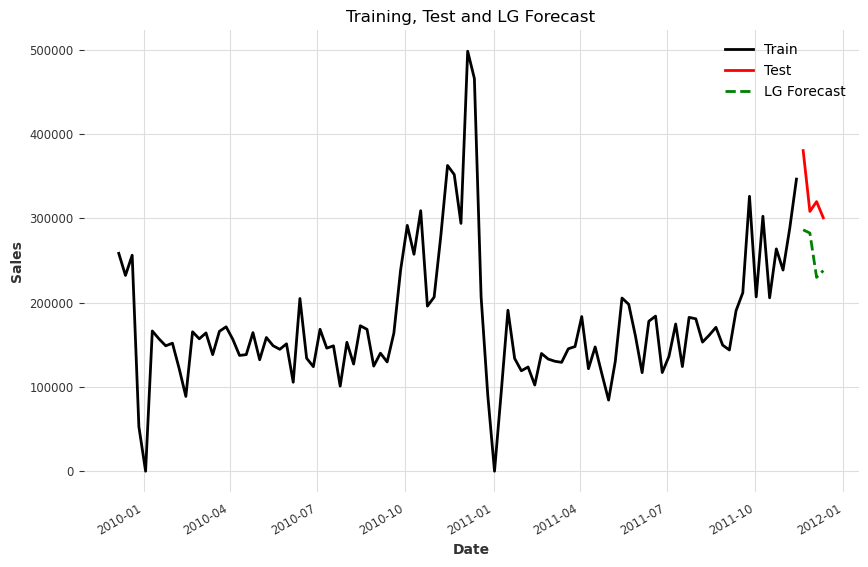

In [24]:
plt.figure(figsize=(10, 6))

train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2, color="red")
lg_forecast.plot(label="LG Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training, Test and LG Forecast")
plt.legend()
plt.show()

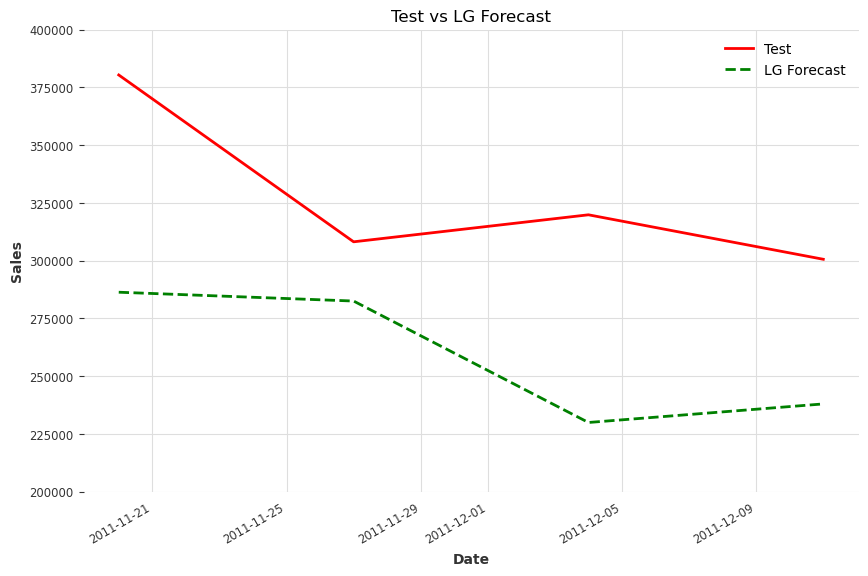

In [25]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

val.plot(label="Test", linewidth=2, color="red")
lg_forecast.plot(label="LG Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Test vs LG Forecast")
plt.legend()
plt.ylim(200000, 400000)
plt.show()

In [26]:
lg_train_df = train.pd_dataframe()
lg_val_df = val.pd_dataframe()
lg_forecast_df = lg_forecast.pd_dataframe()

In [27]:
lg_mse=mean_squared_error(lg_val_df["TotalPrice"],lg_forecast_df["TotalPrice"])
lg_rmse= rmse(lg_val_df["TotalPrice"],lg_forecast_df["TotalPrice"])
lg_mape = mean_absolute_percentage_error(lg_val_df["TotalPrice"], lg_forecast_df["TotalPrice"])
lg_mae = mean_absolute_error(lg_val_df["TotalPrice"], lg_forecast_df["TotalPrice"])

print(f"LR Mean Squared Error (MSE): {fft_mse}")
print(f"LR Root Mean Squared Error (RMSE): {fft_rmse}")
print(f"LR Mean Absolute Percentage Error (MAPE): {fft_mape}")
print(f"LR Mean Absolute Error (MAE): {fft_mae}")

LR Mean Squared Error (MSE): 6067478031.66025
LR Root Mean Squared Error (RMSE): 77894.01794528415
LR Mean Absolute Percentage Error (MAPE): 0.2246476914037172
LR Mean Absolute Error (MAE): 73243.44430546404


### Arima

Why do we use ARIMA model?
Autoregressive Integrated Moving Average (ARIMA) Prediction Model
Autoregressive integrated moving average (ARIMA) models predict future values based on past values. ARIMA makes use of lagged moving averages to smooth time series data. They are widely used in technical analysis to forecast future security prices.

In [28]:
arima_train_df = train.pd_dataframe()
arima_val_df = val.pd_dataframe()

arima_model = ARIMA(arima_train_df['TotalPrice'], order=(1,0,0))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.predict(start=len(train), end=len(train) + len(val) - 1)

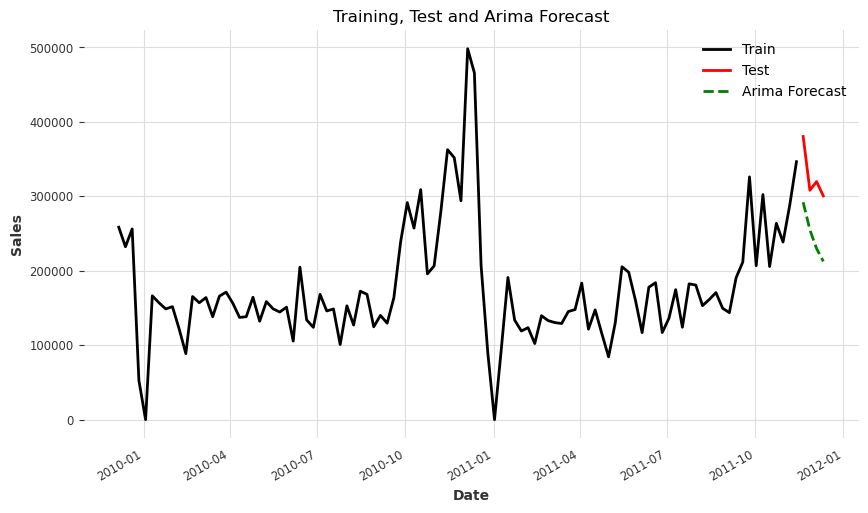

In [29]:
plt.figure(figsize=(10, 6))

train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2, color="red")
arima_forecast.plot(label="Arima Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training, Test and Arima Forecast")
plt.legend()
plt.show()

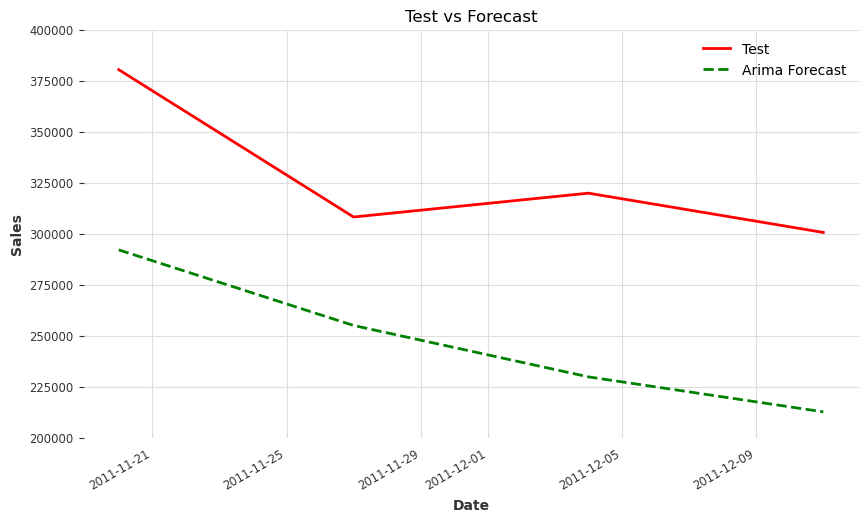

In [30]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

val.plot(label="Test", linewidth=2, color="red")
arima_forecast.plot(label="Arima Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Test vs Forecast")
plt.legend()
plt.ylim(200000, 400000)
plt.show()

In [31]:
arima_mse = mean_squared_error(arima_val_df["TotalPrice"], arima_forecast.values)
arima_rmse = rmse(fft_val_df["TotalPrice"], arima_forecast.values)
arima_mape = mean_absolute_percentage_error(fft_val_df["TotalPrice"], arima_forecast.values)
arima_mae = mean_absolute_error(fft_val_df["TotalPrice"], arima_forecast.values)

print(f"Arima Mean Squared Error (MSE): {arima_mse}")
print(f"Arima Root Mean Squared Error (RMSE): {arima_rmse}")
print(f"Arima Mean Absolute Percentage Error (MAPE): {arima_mape}")
print(f"Arima  Mean Absolute Error (MAE): {arima_mae}")


Arima Mean Squared Error (MSE): 6618196352.778142
Arima Root Mean Squared Error (RMSE): 81352.29777196303
Arima Mean Absolute Percentage Error (MAPE): 0.24469442618411047
Arima  Mean Absolute Error (MAE): 79873.59937015965


### SARIMA

SARIMA models have some advantages over ARIMA models when the data exhibits strong seasonal patterns. For example, if you are forecasting monthly sales data, you may expect higher sales in certain months due to holidays or seasonal demand. SARIMA models can capture this effect and adjust the forecasts accordingly.

In [32]:
sarima_train_df = train.pd_dataframe()
sarima_val_df = val.pd_dataframe()

sarima_model= SARIMAX(sarima_train_df["TotalPrice"], order= (1,0,0), seasonal_order= (0,0,1,52))
sarima_model_fit= sarima_model.fit()
sarima_forecast= sarima_model_fit.predict(len(sarima_train_df), end=len(sarima_train_df) + len(sarima_val_df) -1, dynamic=False, typ="levels").rename("SARIMA predictions")

C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


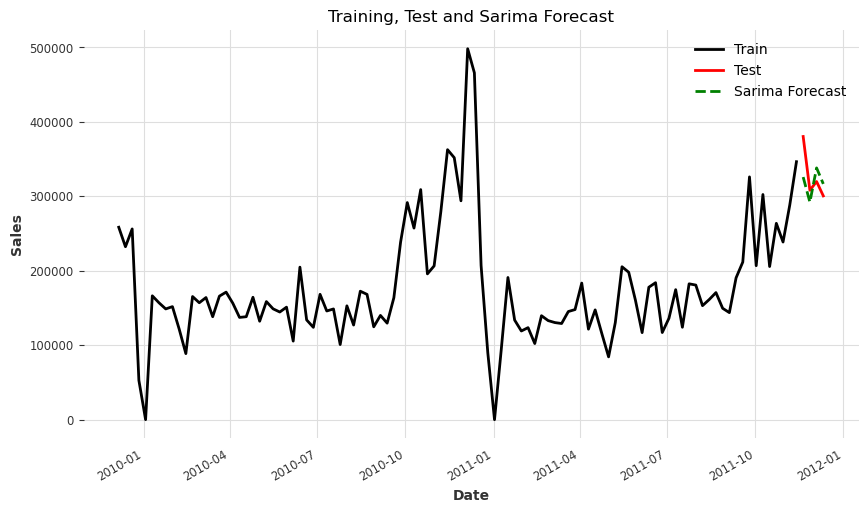

In [33]:
plt.figure(figsize=(10, 6))

train.plot(label="Train", linewidth=2)
val.plot(label="Test", linewidth=2, color="red")
sarima_forecast.plot(label="Sarima Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training, Test and Sarima Forecast")
plt.legend()
plt.show()

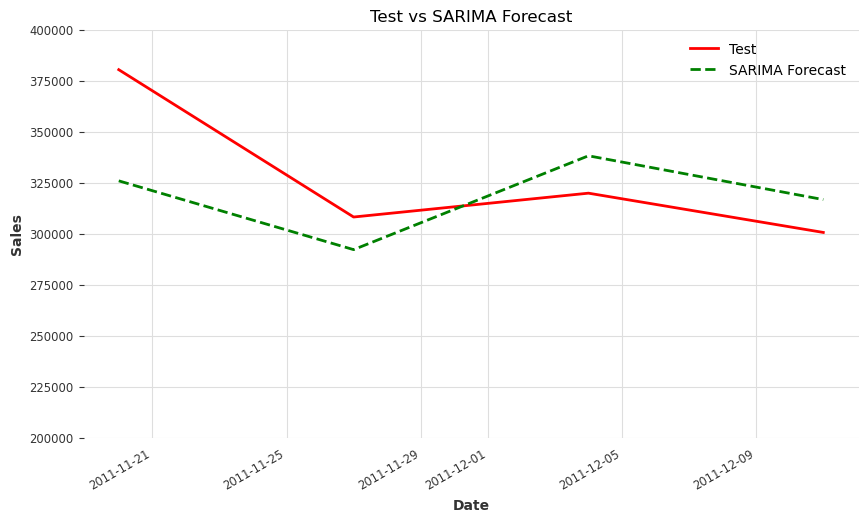

In [34]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

val.plot(label="Test", linewidth=2, color="red")
sarima_forecast.plot(label="SARIMA Forecast", linestyle="--", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Test vs SARIMA Forecast")
plt.legend()
plt.ylim(200000, 400000)
plt.show()

In [35]:
sarima_mse=mean_squared_error(sarima_val_df["TotalPrice"],sarima_forecast.values)
sarima_rmse= rmse(sarima_val_df["TotalPrice"],sarima_forecast.values)
sarima_mape = mean_absolute_percentage_error(sarima_val_df["TotalPrice"], sarima_forecast.values)
sarima_mae = mean_absolute_error(sarima_val_df["TotalPrice"], sarima_forecast.values)

print(f"FFT Mean Squared Error (MSE): {sarima_mse}")
print(f"FFT Root Mean Squared Error (RMSE): {sarima_rmse}")
print(f"FFT Mean Absolute Percentage Error (MAPE): {sarima_mape}")
print(f"FFT Mean Absolute Error (MAE): {sarima_mae}")

FFT Mean Squared Error (MSE): 954844299.0603544
FFT Root Mean Squared Error (RMSE): 30900.554995992457
FFT Mean Absolute Percentage Error (MAPE): 0.07648742364473708
FFT Mean Absolute Error (MAE): 26224.555059859063


## Results

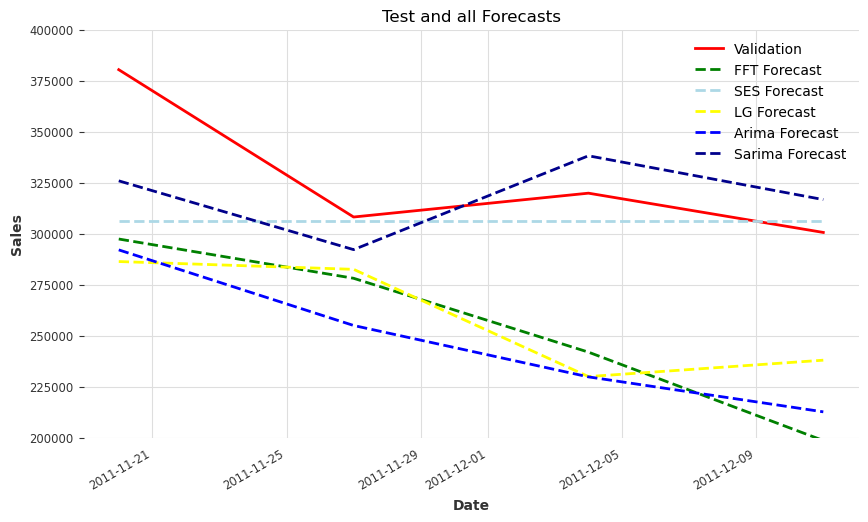

In [36]:
plt.figure(figsize=(10, 6))

val.plot(label="Validation", linewidth=2,color="red")
fft_forecast.plot(label="FFT Forecast", linestyle="--", color="green", linewidth=2)
es_forecast.plot(label="SES Forecast", linestyle="--", color="lightblue", linewidth=2)
lg_forecast.plot(label="LG Forecast", linestyle="--", color="yellow", linewidth=2)
arima_forecast.plot(label="Arima Forecast", linestyle="--", color="blue", linewidth=2)
sarima_forecast.plot(label="Sarima Forecast", linestyle="--", color="darkblue", linewidth=2)


plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Test and all Forecasts")
plt.legend()
plt.ylim(200000, 400000)
plt.show()

In [37]:
fft_mape *= 100
es_mape *= 100
lg_mape *= 100
arima_mape *= 100
sarima_mape *= 100

fft_mae = round(fft_mae, 2)
es_mae = round(es_mae, 2)
lg_mae = round(lg_mae, 2)
arima_mae = round(arima_mae, 2)
sarima_mae = round(sarima_mae, 2)

table = PrettyTable()
table.field_names = ["Model", "MAPE", "MAE"]
table.add_row(["FFT", f"{fft_mape:.2f}%", fft_mae])
table.add_row(["SES", f"{es_mape:.2f}%", es_mae])
table.add_row(["LG", f"{lg_mape:.2f}%", lg_mae])
table.add_row(["ARIMA", f"{arima_mape:.2f}%", arima_mae])
table.add_row(["SARIMA", f"{sarima_mape:.2f}%", sarima_mae])

In [38]:
print(table)

+--------+--------+----------+
| Model  |  MAPE  |   MAE    |
+--------+--------+----------+
|  FFT   | 22.46% | 73243.44 |
|  SES   | 6.53%  | 23733.86 |
|   LG   | 20.49% | 68054.0  |
| ARIMA  | 24.47% | 79873.6  |
| SARIMA | 7.65%  | 26224.56 |
+--------+--------+----------+


## Result Interpretation

Fast Fourier Transform (FFT)

The FFT model has a relatively high MAPE, indicating that the percentage difference between the predicted and actual values is, on average, 22.46%. This might suggest that the model struggles with accurately capturing the variation in the time series data. The MAE of 73243.44 suggests that, on average, the predicted values differ from the actual values by this amount.

Simple Exponential Smoothing

SES is a basic exponential smoothing method that is effective for capturing trends and seasonality in relatively simple time series. If your data has clear trends and seasonality, SES could perform well. SES performs quite well compared to FFT. The low MAPE of 6.53% indicates a smaller percentage difference between predicted and actual values, suggesting better accuracy. The MAE of 23733.86 is also relatively low, indicating smaller absolute errors.

Linear Regression

Linear regression assumes a linear relationship between the input features and the target variable. If the underlying patterns in your time series are more complex or non-linear, linear regression might struggle to capture them effectively.

Arima

ARIMA has a relatively high MAPE, indicating a substantial percentage difference between predicted and actual values. The MAE of 79873.6 is also high, suggesting larger absolute errors. ARIMA models might struggle if the time series has complex patterns that are not well-captured by its parameters.

SARIMA

SARIMA outperforms ARIMA in terms of MAPE and MAE. The lower MAPE suggests a smaller percentage difference, and the lower MAE indicates smaller absolute errors. SARIMA models are an extension of ARIMA with seasonality considerations, and in this case, it appears to have captured the underlying patterns more effectively.

## Predict weekly aggregated sales for 4 weeks in advance

In [39]:
series_pd = series.pd_dataframe()

model = FFT(nr_freqs_to_keep = 8)
model.fit(series)
fft_forecast_4weeks = model.predict(4)

model = SimpleExpSmoothing(series_pd)
fit_model = model.fit(smoothing_level=0.5)
es_forecast_4weeks = fit_model.forecast(4)

model = LinearRegressionModel(lags=20)
model.fit(series)
lg_forecast_4weeks = model.predict(4)

arima_model = ARIMA(series_pd, order=(1, 0, 0))
arima_model_fit = arima_model.fit()
arima_forecast_4weeks = arima_model_fit.forecast(steps=4)

sarima_model = SARIMAX(series_pd, order=(1, 0, 0), seasonal_order=(0, 0, 1, 52))
sarima_model_fit = sarima_model.fit()
sarima_forecast_4weeks = sarima_model_fit.predict(start= 106, end=109)

C:\Users\Bert\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


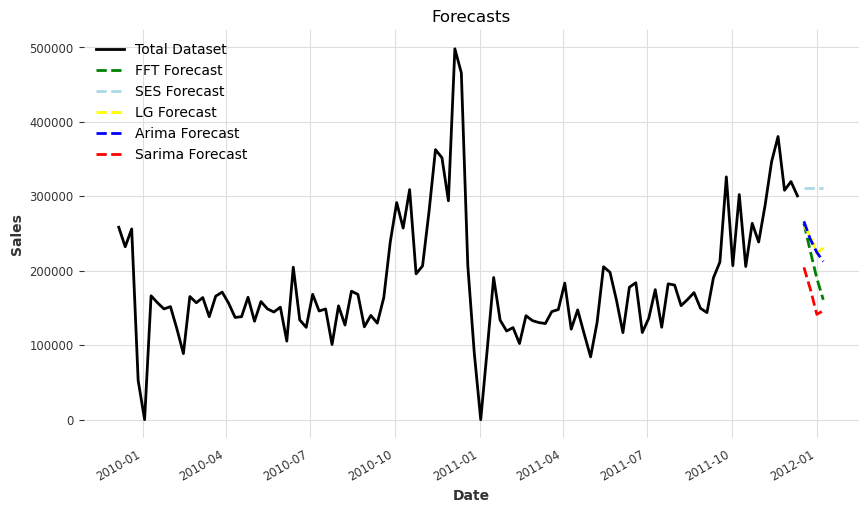

In [40]:
plt.figure(figsize=(10, 6))
series.plot(label = "Total Dataset", linewidth=2)
fft_forecast_4weeks.plot(label="FFT Forecast", linestyle="--", color="green", linewidth=2)
es_forecast_4weeks.plot(label="SES Forecast", linestyle="--", color="lightblue", linewidth=2)
lg_forecast_4weeks.plot(label="LG Forecast", linestyle="--", color="yellow", linewidth=2)
arima_forecast_4weeks.plot(label="Arima Forecast", linestyle="--", color="blue", linewidth=2)
sarima_forecast_4weeks.plot(label="Sarima Forecast", linestyle="--", color="red", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Forecasts")
plt.legend()
plt.show()

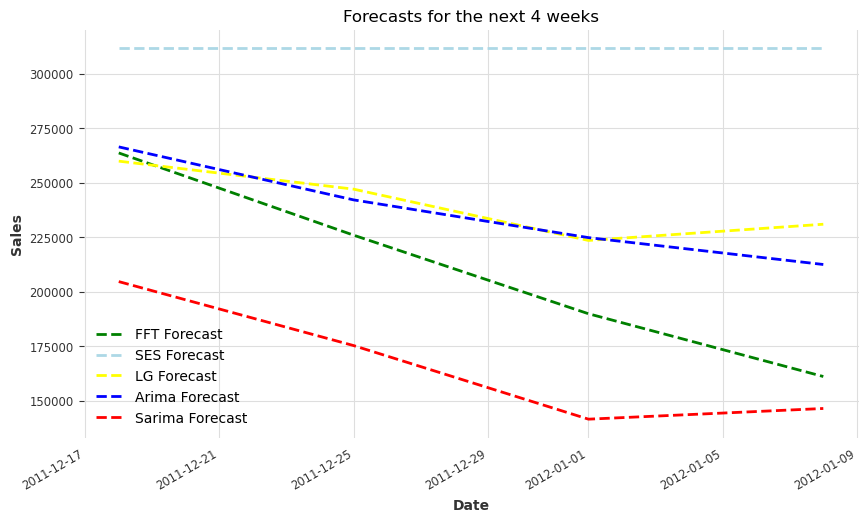

In [41]:
plt.figure(figsize=(10, 6))
fft_forecast_4weeks.plot(label="FFT Forecast", linestyle="--", color="green", linewidth=2)
es_forecast_4weeks.plot(label="SES Forecast", linestyle="--", color="lightblue", linewidth=2)
lg_forecast_4weeks.plot(label="LG Forecast", linestyle="--", color="yellow", linewidth=2)
arima_forecast_4weeks.plot(label="Arima Forecast", linestyle="--", color="blue", linewidth=2)
sarima_forecast_4weeks.plot(label="Sarima Forecast", linestyle="--", color="red", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Forecasts for the next 4 weeks")
plt.legend()
plt.show()